Training model using kaggle Dataset

In [262]:
#importing 

import numpy as np
import pandas as pd

import matplotlib.pyplot  as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,ConfusionMatrixDisplay

from tensorflow import keras
from tensorflow.keras import layers


import tensorflow as tf
from tensorflow.keras.layers import TextVectorization




#Reading data from CSV  
data = pd.read_csv('/../fake_job_postings.csv')

In [263]:
#Displaying training Data
data.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


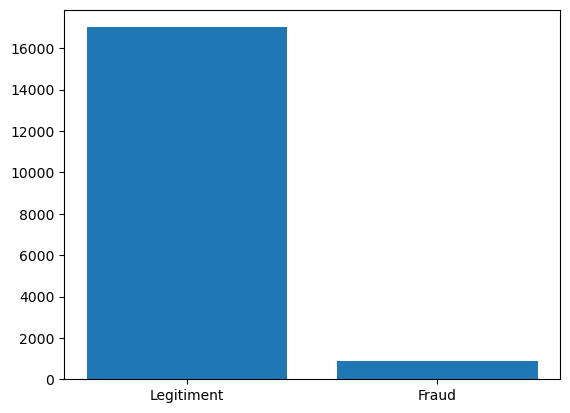

In [264]:
#Checking how much of the data is fraud vs legit

x = data['fraudulent'].value_counts()
fig, ax = plt.subplots()
titles = ['legitimate', 'Fraud']
ax.bar(titles, x )
plt.show()

In [265]:
#When training with 95% not fraud the model just predicts not fraud on all entries leaving it unable to identify fraudulent entries

fraud = data[data['fraudulent']== 1]

#Adjusting legitimate entries avalable to training and testing dataset
#Now adjusted for with class weithing when fitting model
Legit = data[data['fraudulent']== 0][:8000]

#Recombining fraudulent and reduced legitimate dataset
data_reduced = pd.concat([fraud, Legit], ignore_index=True, axis=0)

In [266]:
#Defining features and the target to be used for training the model based upon avalable data from web scraping app
features = data_reduced[['title', 'location','description','benefits', 'requirements','employment_type' ]]
target = data_reduced['fraudulent']


In [267]:
#replacing NA with space  
features.fillna(" ",inplace=True)
features.isnull().sum()


C:\Users\aloll\AppData\Local\Temp\ipykernel_32464\1001746591.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(" ",inplace=True)


title              0
location           0
description        0
benefits           0
requirements       0
employment_type    0
dtype: int64

In [268]:
#Optimizing to only include columns in model where there are more entries like location, title and description.  
#Including to manny null/blank values in the already starved fraud dataset causes issuse due to lack of data.

fraud[['title', 'location','description','benefits', 'requirements', 'company_profile','employment_type' ]].isnull().sum().sort_values()

title                0
description          1
location            19
requirements       154
employment_type    241
benefits           364
company_profile    587
dtype: int64

In [269]:
#Change each chosen entry into a single string
#Columns with less null values in fraud dataset in particular are usefull
# \xa0 is a unicode no-break space that is prevelent in a few of the entries that needed to be removed 

concat_data = []
for i in range(len(features)):
    entry = features['description'][i] + ' '
    entry = entry + features['title'][i] + ' '
    entry = entry + features['location'][i] + ' '
    entry = entry + features['employment_type'][i] 
    concat_data.append(entry.strip().replace('\xa0', ''))  

In [270]:
#Confirming long string of data
concat_data[0]

'IC&amp;E Technician | Bakersfield, CA Mt. PosoPrincipal Duties and Responsibilities:Calibrates, tests, maintains, troubleshoots, and installs all power plant instrumentation, control systems and electrical equipment.Performs maintenance on motor control centers, motor operated valves, generators, excitation equipment and motors.Performs preventive, predictive and corrective maintenance on equipment, coordinating work with various team members.Designs and installs new equipment and/or system modifications.Troubleshoots and performs maintenance on DC backup power equipment, process controls, programmable logic controls (PLC), and emission monitoring equipment.Uses maintenance reporting system to record time and material use, problem identified and corrected, and further action required; provides complete history of maintenance on equipment.Schedule, coordinate, work with and monitor contractors on specific tasks, as required.Follows safe working practices at all times.Identifies safety 

In [271]:
#finding the rough count of words in the 3rd quartile of entries to pass to the tokenizers max length

seq_lens = [seq.count(' ') for seq in concat_data]
q3 = np.quantile(seq_lens,.75)
print(q3)

227.0


In [272]:
#creating a layer for tokens model to change the text into numbers stripping punctuation and case
vectorize_layer = TextVectorization(max_tokens=10000, standardize='lower_and_strip_punctuation', output_sequence_length=int(q3))

#training token layer
vectorize_layer.adapt(concat_data)

In [273]:
#Using tf to make a tokenizer
#Model can be used to map future datasets and keep tokens consitent

Tokens = tf.keras.models.Sequential()
Tokens.add(tf.keras.Input(shape=(1,), dtype=tf.string))
Tokens.add(vectorize_layer)
x_tokens = Tokens.predict(concat_data)

#Option to save tokenizer
#Tokens.save('tokenizer.tf')

278/278 [==============================] - 1s 2ms/step


In [274]:
#confirming tokenization 
print(x_tokens[9])


[ 169  156 1264    1   70  621   49   10   81    8    3    1  950 2138
    2 1532    5    3    1  571 7275   70  621  295   16 2615    1    1
   70   23  294    1  135    3 7275   70  621    1    2 1238    3  195
    5    3 7275    1    2  491    3  835    5    3 7275   70    1  135
    2 1238    3   70 5966    5    3    1    5    1    2  135    3 7275
    1    1    2   47    3 7275  817  102    1    3 7275   70    5  153
 3396    2    1    2   47    3 7275   70 2325  195    1    3 7275 1425
  796    2  176   70    1 1397    1    5    3    1 2029    1  258   16
  214   36    3 7275  232    1    2    1    2   34 9977  144    6 2405
    9    6  725  356  134    5   34    7    1    1    6  189   97   14
   27    6    1    5  227 1430  153   70  351   64    1   47    5 5791
   24    1  845    1    1   70 2077   34    9    1    1  621  195   10
    1   61    3   97  101   15    1 1233  821  390    5   78    9    1
    2  405   61    2    3 1486    4 4130    1   16    6   42    4    3
  203 

In [275]:
#building testing and training groups for the model
x_train,x_test,y_train,y_test = train_test_split(x_tokens,target,test_size=0.2,random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(7092, 227)
(1774, 227)
(7092,)
(1774,)


In [276]:
#setting input sizes for the first layer

VOCAB_SIZE = 10000 + 1
VEC_SIZE = 100
TOKEN_SIZE = int(q3)

In [277]:
#Creating the ml model
#using CuDNNGRU 

from tensorflow.compat.v1.keras.layers import CuDNNGRU

model = keras.Sequential()
model.add(layers.Embedding(input_dim=VOCAB_SIZE,
                           output_dim=VEC_SIZE,
                           input_length=TOKEN_SIZE
                          ))



model.add(CuDNNGRU(512,return_sequences=True))
model.add(CuDNNGRU(1024,return_sequences=True))
model.add(CuDNNGRU(2048))
model.add(layers.Dense(1,activation="sigmoid"))

model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [278]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 227, 100)          1000100   
                                                                 
 cu_dnngru_39 (CuDNNGRU)     (None, 227, 512)          943104    
                                                                 
 cu_dnngru_40 (CuDNNGRU)     (None, 227, 1024)         4724736   
                                                                 
 cu_dnngru_41 (CuDNNGRU)     (None, 2048)              18886656  
                                                                 
 dense_13 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 25,556,645
Trainable params: 25,556,645
Non-trainable params: 0
_________________________________________________________________


In [279]:
#Gets the percent of fraudulent entries compared to the whole 
neg, pos = np.bincount(data_reduced['fraudulent'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 8866
    Positive: 866 (9.77% of total)



In [280]:
#setting class weights based on how many true and false fraud entries there are so the model is not overwelmed by the large amount of legitimate emails
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.55
Weight for class 1: 5.12


In [281]:
#Training the model
hist = model.fit(x_train,y_train,epochs=13, class_weight=class_weight)

Epoch 1/13
222/222 [==============================] - 47s 207ms/step - loss: 0.7314 - accuracy: 0.4784
Epoch 2/13
222/222 [==============================] - 46s 206ms/step - loss: 0.5942 - accuracy: 0.6383
Epoch 3/13
222/222 [==============================] - 46s 208ms/step - loss: 0.3480 - accuracy: 0.8460
Epoch 4/13
222/222 [==============================] - 46s 208ms/step - loss: 0.3757 - accuracy: 0.8299
Epoch 5/13
222/222 [==============================] - 46s 206ms/step - loss: 0.4222 - accuracy: 0.8025
Epoch 6/13
222/222 [==============================] - 47s 210ms/step - loss: 0.3072 - accuracy: 0.8697
Epoch 7/13
222/222 [==============================] - 46s 206ms/step - loss: 0.2633 - accuracy: 0.8917
Epoch 8/13
222/222 [==============================] - 45s 204ms/step - loss: 0.2382 - accuracy: 0.8981
Epoch 9/13
222/222 [==============================] - 46s 205ms/step - loss: 0.2085 - accuracy: 0.9169
Epoch 10/13
222/222 [==============================] - 46s 205ms/step - l

In [283]:
#Testing trained model to confirm its not over or under fitteded

model_loss, model_accuracy = model.evaluate(x_test,y_test,verbose=2)

print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

56/56 - 2s - loss: 0.5643 - accuracy: 0.8140 - 2s/epoch - 27ms/step
Loss: 0.5642573833465576, Accuracy: 0.8139796853065491


In [284]:
#making predicitons on the test data for the confusion matrix
y_pred = model.predict(x_test)

#Due to the use of the sigmoid output function when building the model, values come in probablities between 1 and 0
#below funciton converts it from probablitiy to boolean values or true/false
y_pred = np.where(y_pred > .5, 1,0)

56/56 [==============================] - 2s 26ms/step


Accuracy score of model is 81.39797068771138%


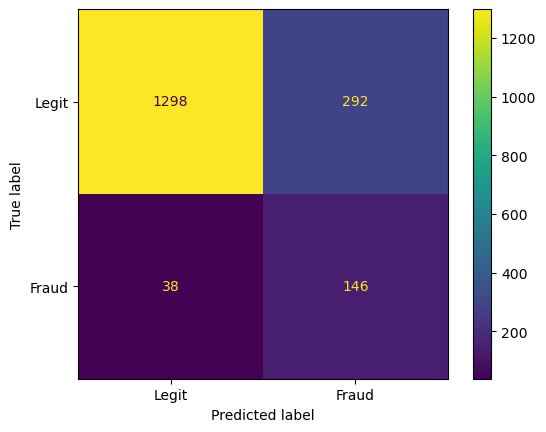

In [285]:
#making a Confusion Matrix using the test data

print("Accuracy score of model is {}%".format(accuracy_score(y_pred=y_pred,y_true=y_test)*100))


conf_matrix = confusion_matrix(y_true=y_test ,y_pred=y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['Leg', 'Fraud'])

cm_display.plot()
plt.show()

In [286]:
#Saving model and token 
Tokens.save('tokenizer_finial.tf')
model.save('LanguageML_finial.keras')

INFO:tensorflow:Assets written to: tokenizer_finial.tf\assets
